# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。



## $g(z) = \frac{1}{1+e^{−z}}.$

線形回帰の仮定関数は次の式でした。

## $h_\theta(x) = \theta^T \cdot x.$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

## $h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.$

$x$:特徴量ベクトル

$θ$:パラメータ（重み）ベクトル

In [232]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter("ignore")

In [31]:
#メソッドの中に入れる形
def _linear_hypothesis(self, X):
    """
    線形の仮定関数を計算する
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
    訓練データ
    Returns
    -------
    次の形のndarray, shape (n_samples, 1)
    線形の仮定関数による推定結果
    """
    if X.ndim == 1:  #Xが１次元の時
        X = X[:,np.newaxis]  #２次元に変形
    if (X.shape[1] != self.theta.T.shape[0])&(self.bias==True):
        #x_0が含まれていない状態でXを受け取り（外部からのメソッド呼び出しを想定）、かつバイアス項を使う時
        X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)
    return 1/(1+np.exp(np.dot(X,self.theta.T)))

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

## $\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$

## $\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0$

## $\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1$

α
  : 学習率


i
 : サンプルのインデックス


j
 : 特徴量のインデックス


m
 : 入力されるデータの数


h
(
θ
)
 : 仮定関数


x
 : 特徴量ベクトル


θ
 : パラメータ（重み）ベクトル


x
(
i
)
 : i番目のサンプルの特徴量ベクトル


y
(
i
)
 : i番目のサンプルの正解ラベル


θ
j
 : j番目のパラメータ（重み）


λ
 : 正則化パラメータ

In [71]:
#クラス内に定義したメソッドの形をそのまま取り出した
#27~31行目でスライスを用いてθの更新を行っている
def _gradient_descent(self, X,error=np.empty(1)):
    """
    θとXを用いて次のθを計算する
    Parameters
        ---------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
         
    error:次の形のndarray,shape (n_samples,)
        予測値と正解値の残差
    --------
    Returns
     --------
    次の形のndarray,shape(n_samples,)
    予測値と正解値の残差
    """
    if error.shape == (1,):  #errorが渡されていない時
        #θが与えられていない時だけ初期化する
        if self.theta.shape == (1,):
            self.theta = np.ones(X.shape[1]).reshape(1,-1)  #θを1で初期化
        error = (self._linear_hypothesis(X) - self.y).reshape(1,-1)
    else:  #errorが渡されている時
        error = (self.predict_proba(X) - self.y).flatten()
    #θの更新式
    if self.bias == True:  #バイアス項がある場合
            self.theta[0,0] = self.theta[0,0]- (self.lr/X.shape[0])*error@self.X[:,0]
            self.theta[0,1:] = self.theta[0,1:] - (self.lr/X.shape[0])*error@self.X[:,1:]+ (self.lam/X.shape[0])*self.theta[0,1:]
    else:  #バイアス項がない場合
        self.theta = self.theta - (self.lr/X.shape[0])*error@self.X+ (self.lam/X.shape[0])*self.theta
    return error

# 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 
$
h_θ
(
x
)
 $の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

In [167]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self,num_iter=1000,lam=1e-3,lr=1e-2,bias=True, verbose=False,name="empty"):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.lam = lam
        #すでに使ったことのあるクラスだった場合にnameにクラス名をstr型で指定すると,
        #filesにあるバイナリファイルからすでに計算済みのθを取ってくる.
        save_filename = "files/"+name+".npz"
        #バイナリファイルからndarray読み込み
        if name == "empty":
            self.theta = np.empty(1)
        else:
            self.theta = np.load(save_filename)[name]
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    def fit(self, X, y, X_val=np.empty(1), y_val=np.empty(1)):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        #訓練用データ、検証用データの形を整える
        if y.ndim == 1:  #yが１次元のとき
            self.y = y[:,np.newaxis]  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
        else:
            self.y = y
        self.y_val = y_val
        if self.bias == True:  #バイアス項がある時
            if X.ndim == 1:  #１次元の時(２次元であればここはスルー)
                X = X[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
            self.X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
            if(len(X_val) != 1) & (len(y_val) != 1): #検証データが入力された場合（入力されない場合は何もしない）
                if X_val.ndim == 1:  #検証データが１次元の時
                    X_val = X_val[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
                self.X_val = np.concatenate([np.ones(X_val.shape[0])[:,np.newaxis],X_val],axis=1)  #バイアス項を結合
        
        else:  #バイアス項がない時
            if X.ndim ==1:  #Xが１次元の時
                self.X = X[:,np.newaxis]
                self.X_val = X_val[:,np.newaxis]
            else:  #Xが２次元の時
                self.X = X
                self.X_val = X_val
        
        #ここから計算
        if (len(X_val) != 1) & (len(y_val) != 1):  #検証データが入力された場合
            error = self._gradient_descent(self.X)
            self.loss[0] = loss_func(self.predict(self.X),y,self.theta,self.lam)
            self.val_loss[0] = loss_func(self.predict(self.X_val),y_val,self.theta,self.lam)
            for i in range(self.iter-1):  #iter-1回,_gradient_descentを実行する
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict_proba(self.X),self.y,self.theta,self.lam)
                self.val_loss[i+1] = loss_func(self.predict_proba(self.X_val),self.y_val,self.theta,self.lam)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回目".format(i+1))
                    print("theta:{}".format(self.theta))
                    print("損失:{}".format(self.val_loss[i+1]))
                    print("精度（平均2乗誤差）:{}\n".format(MSE(self.predict(self.X_val),self.y_val)))
        else:  #検証データが入力されない場合
            error = self._gradient_descent(self.X)
            self.loss[0] = loss_func(self.predict(self.X),y,self.theta,self.lam)
            self.val_loss[0] = loss_func(self.predict(self.X_val),y_val,self.theta,self.lam)
            for i in range(self.iter-1):
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict_proba(self.X),self.y,self.theta,self.lam)
                self.val_loss[i+1] = loss_func(self.predict_proba(self.X_val),self.y_val,self.theta,self.lam)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回目".format(i+1))
                    print("theta:\n{}".format(self.theta))

    def _gradient_descent(self, X,error=np.empty(1)):
        """
        θとXを用いて次のθを計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
            
        error:次の形のndarray,shape (n_samples,)
            予測値と正解値の残差
        --------
        Returns
        --------
        次の形のndarray,shape(n_samples,)
        予測値と正解値の残差
        """
        if error.shape == (1,):  #errorが渡されていない時
            #θが与えられていない時だけ初期化する
            if self.theta.shape == (1,):
                self.theta = np.ones(X.shape[1]).reshape(1,-1)  #θを1で初期化
            error = (self._linear_hypothesis(X) - self.y).reshape(1,-1)
        else:  #errorが渡されている時
            error = (self.predict_proba(X) - self.y).flatten()
        if self.bias == True:  #バイアス項がある場合
            self.theta[0,0] = self.theta[0,0]- (self.lr/X.shape[0])*error@self.X[:,0]
            self.theta[0,1:] = self.theta[0,1:] - (self.lr/X.shape[0])*error@self.X[:,1:]+ (self.lam/X.shape[0])*self.theta[0,1:]
        else:  #バイアス項がない場合
            self.theta = self.theta - (self.lr/X.shape[0])*error@self.X+ (self.lam/X.shape[0])*self.theta
        return error

    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果
        """
        if X.ndim == 1:  #Xが１次元の時
            X = X[:,np.newaxis]  #２次元に変形
        if (X.shape[1] != self.theta.T.shape[0])&(self.bias==True):
            #x_0が含まれていない状態でXを受け取り（外部からのメソッド呼び出しを想定）、かつバイアス項を使う時
            X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)
        return np.dot(X,self.theta.T)
    
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        #閾値を設定
        threshold = 0.5
        X_pred = self.predict_proba(X).flatten()
        X_pred[X_pred<threshold]  = 0
        X_pred[X_pred>=threshold] = 1
        return X_pred
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
    
        return 1/(1+np.exp(-self._linear_hypothesis(X)))

# 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。

### $
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$

m
  : 入力されるデータの数


h(θ)
 : 仮定関数


x
 : 特徴量ベクトル


θ
 : パラメータ（重み）ベクトル


x
(
i
)
 : i番目のサンプルの特徴量ベクトル


y
(
i
)
 : i番目のサンプルの正解ラベル


θ
j
 : j番目のパラメータ（重み）


n
 : 特徴量の数


λ
 : 正則化パラメータ

In [107]:
def loss_func(h_x,y,theta,lam):
    a = -y*np.log(h_x)
    b = (1-y)*np.log(1-h_x)
    c = (lam/(2*len(h_x)))*np.sum(theta[1:]**2)
    return (np.sum(a-b)/len(h_x)) + c

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [362]:
iris = load_iris()
X = pd.DataFrame(iris.data[50:,:],columns = ["sepal_length","sepal_width","petal_length","petal_width"])
y = pd.DataFrame(iris.target[50:],columns  = ["Species"])
y[:50],y[50:100] = 0,1

In [363]:
x_train,x_test,y_train,y_test = train_test_split(np.array(X),np.array(y),train_size=0.75,random_state=0)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [364]:
#ここから検証
slr = ScratchLogisticRegression(lr = 1,bias=False)
slr.fit(x_train,y_train,x_test,y_test)
y_pred = slr.predict(x_test)
y_pred_proba = slr.predict_proba(x_test)
print(accuracy_score(y_test,y_pred))

0.92


In [365]:
slr = ScratchLogisticRegression(lr = 0.1)
slr.fit(x_train,y_train,x_test,y_test)
y_pred = slr.predict(x_test)
y_pred_proba = slr.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.92

In [366]:
slr = ScratchLogisticRegression(lr = 1e-2)
slr.fit(x_train,y_train,x_test,y_test)
y_pred = slr.predict(x_test)
y_pred_proba = slr.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.92

In [367]:
slr2 = ScratchLogisticRegression(lr = 1e-3)
slr2.fit(x_train,y_train,x_test,y_test)
y_pred = slr2.predict(x_test)
y_pred_proba = slr2.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.84

In [368]:
slr3 = ScratchLogisticRegression(lr = 1e-4)
slr3.fit(x_train,y_train,x_test,y_test)
y_pred = slr3.predict(x_test)
y_pred_proba = slr3.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.84

In [369]:
slr4 = ScratchLogisticRegression(lr = 1e-5)
slr4.fit(x_train,y_train,x_test,y_test)
y_pred = slr4.predict(x_test)
y_pred_proba = slr4.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.84

### lr = 1：正解率92% 
### lr = 1e-1：正解率92% 
### lr = 1e-2：正解率92% 
### lr = 1e-3：正解率84%  
### lr = 1e-4：正解率84%
### lr = 1e-5：正解率84%
### (イテレーション数:10000,正則化パラメータ:1e-3)

In [370]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
y_proba = lr.predict_proba(x_test)
accuracy_score(y_test,y_pred)

0.92

### scikit-learnは92%だった

# 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

now calculating....

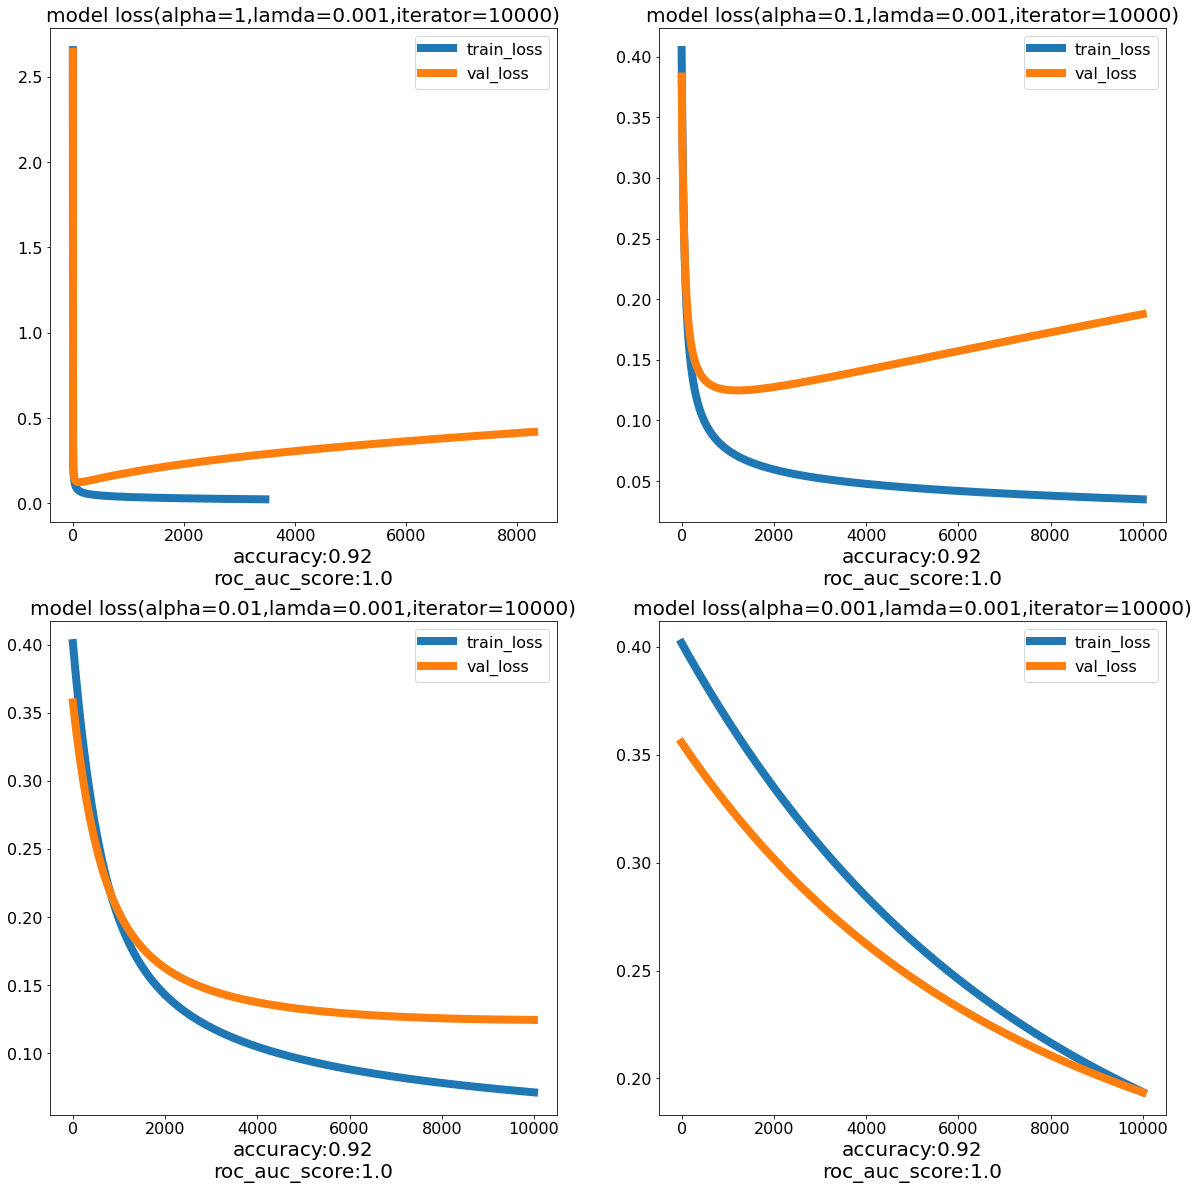

In [373]:
# 学習率によってどのように損失が変わるかを可視化する
alpha = [1,1e-1,1e-2,1e-3]
lam = 1e-3
num_iter = 10000
fig,ax = plt.subplots(2,2,figsize=(20,20))
j = 0
count = 0
print("now calculating",end="")
for i in range(2):
    for j in range(2):
        slr_plot = ScratchLogisticRegression(lr = alpha[count],lam=lam,num_iter=num_iter)
        slr_plot.fit(x_train,y_train,x_test,y_test)
        y_pred = slr_plot.predict(x_test)
        accuracy = accuracy_score(y_test,y_pred)
        y_pred_proba = slr.predict_proba(x_test)
        print(".",end="")
        #ここからグラフの描画
        ax[i,j].set_title("model loss(alpha={},lamda={},iterator={})".format(slr_plot.lr,slr_plot.lam,slr_plot.iter),size=20)
        ax[i,j].set_xlabel("accuracy:{}\nroc_auc_score:{}"\
                           .format(accuracy,roc_auc),size=20)
        ax[i,j].plot(np.arange(len(slr_plot.loss)),slr_plot.loss,label="train_loss",linewidth=8)
        ax[i,j].plot(np.arange(len(slr_plot.val_loss)),slr_plot.val_loss,label="val_loss",linewidth=8)
        ax[i,j].legend()
        count += 1
plt.show()

### 学習率は0.01が良さげなので、これを固定してλを動かしてみる

now calculating....

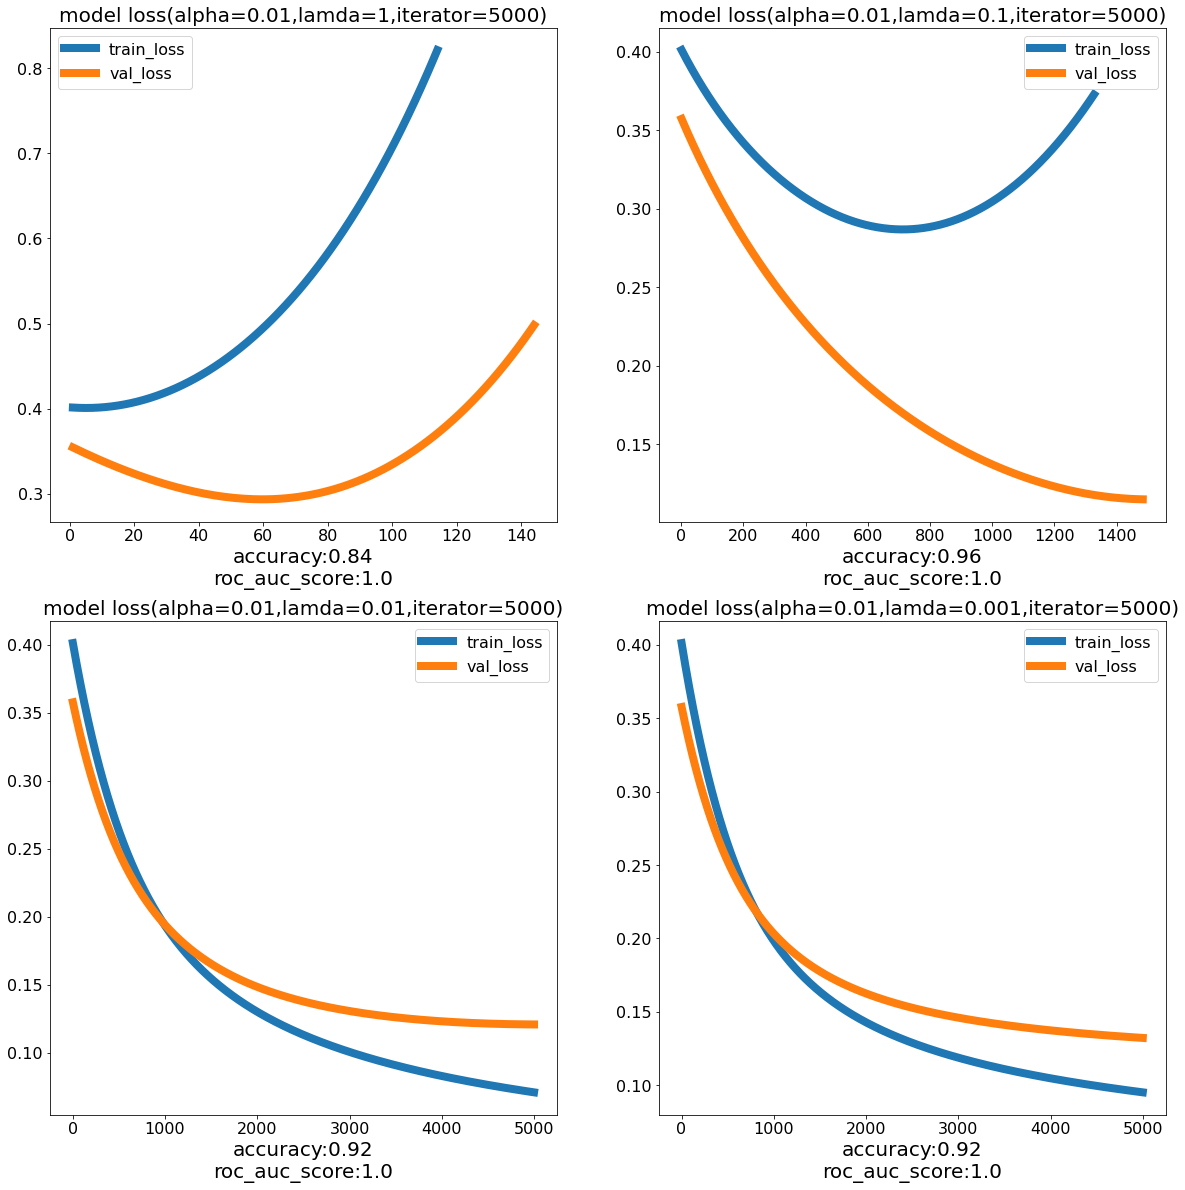

In [374]:
# 学習率によってどのように損失が変わるかを可視化する
alpha = 1e-2
lam = [1,1e-1,1e-2,1e-3]
num_iter = 5000
fig,ax = plt.subplots(2,2,figsize=(20,20))
j = 0
count = 0
print("now calculating",end="")
for i in range(2):
    for j in range(2):
        slr_plot = ScratchLogisticRegression(lr = alpha,lam=lam[count],num_iter=num_iter)
        slr_plot.fit(x_train,y_train,x_test,y_test)
        y_pred = slr_plot.predict(x_test)
        accuracy = accuracy_score(y_test,y_pred)
        roc_auc = roc_auc_score(y_test,y_pred_proba)
        y_pred_proba = slr.predict_proba(x_test)
        print(".",end="")
        #ここからグラフの描画
        ax[i,j].set_title("model loss(alpha={},lamda={},iterator={})".format(slr_plot.lr,slr_plot.lam,slr_plot.iter),size=20)
        ax[i,j].set_xlabel("accuracy:{}\nroc_auc_score:{}"\
                           .format(accuracy,roc_auc),size=20)
        ax[i,j].plot(np.arange(len(slr_plot.loss)),slr_plot.loss,label="train_loss",linewidth=8)
        ax[i,j].plot(np.arange(len(slr_plot.val_loss)),slr_plot.val_loss,label="val_loss",linewidth=8)
        ax[i,j].legend()
        count += 1
plt.show()

# 【問題7】決定領域の可視化
決定領域を可視化してください。

In [355]:
#3次元で可視化するために特徴量を２つにする
X = pd.DataFrame(iris.data[50:,2:4],columns = ["sepal_width","petal_length"])
y = pd.DataFrame(iris.target[50:],columns  = ["Species"])
y[:50],y[50:100] = 0,1
x_train,x_test,y_train,y_test = train_test_split(np.array(X),np.array(y),train_size=0.75,random_state=0)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [356]:
slr_plot2 = ScratchLogisticRegression(lr=1e-2)
slr_plot2.fit(x_train,y_train,x_test,y_test)
y_pred = slr_plot2.predict(x_test)
accuracy_score(y_test,y_pred)

0.96

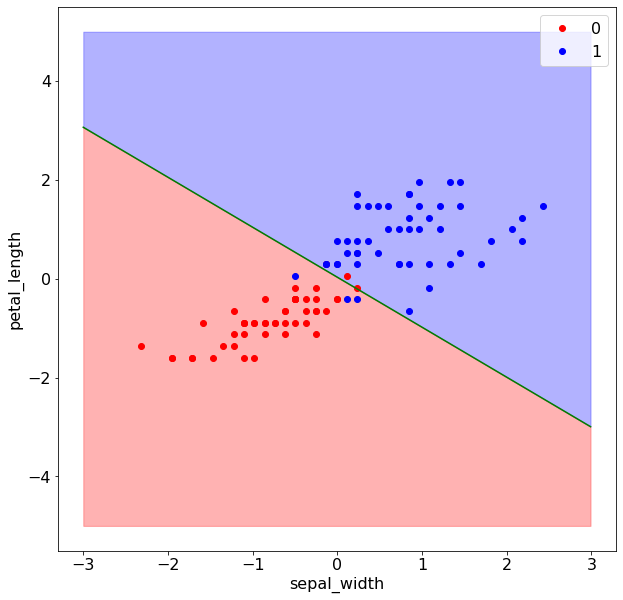

In [361]:
X2 = StandardScaler().fit_transform(np.array(X))
x = np.arange(-3,3,0.01)
c = slr_plot2.theta[0,0]
a = slr_plot2.theta[0,1]
b = slr_plot2.theta[0,2]
y = (-a*x-c+0.5)/b

bias = slr_plot2.theta[0,0]
fig,ax1 = plt.subplots(1,1,figsize=(10,10))
ax1.set_xlabel(X.keys()[0])
ax1.set_ylabel(X.keys()[1])

# データプロットする。
x1 = X2[:50,0]
y1 = X2[:50,1]
x2 = X2[50:100,0]
y2 = X2[50:100,1]
ax1.plot(x1,y1,marker="o",linestyle="None",color="r",label=0)
ax1.plot(x2,y2,marker="o",linestyle="None",color="b",label=1)
ax1.plot(x,y,linestyle="-",color = "g")
ax1.fill_between(x,y,5,color="b",alpha=0.3)
ax1.fill_between(x,y,-5,color="r",alpha=0.3)
ax1.legend()
# グラフを表示する。
plt.show()
plt.close()

# 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

ScratchLogisticRegressionをインスタンス化するときにnameに、  
【すでに使ったことがあり、"files/[インスタンス名].npz"にθを保存してあるインスタンス名】  
をstr型で指定すると、θをそのファイルから取ってきた値で初期化するようにコンストラクタを変更した。  
以下に、具体的にこれを用いた例を示す。

In [358]:
slr = ScratchLogisticRegression(lr = 1e-2)
slr.fit(x_train,y_train,x_test,y_test)
y_pred = slr.predict(x_test)
print("正解率:",accuracy_score(y_test,y_pred))
np.savez("files/slr",slr = slr.theta)  #ここでθを保存し、次回以降呼び出せるようにした
npz_kw = np.load("files/slr.npz")
print("theta:",npz_kw["slr"])

正解率: 0.96
theta: [[0.44580696 1.6966295  1.67742413]]


In [359]:
#インスタンス化した時点でthetaに、上で求めた値が入っているのがわかる
slr2 = ScratchLogisticRegression(lr = 1e-2,name="slr")
print("theta:",slr2.theta)

theta: [[0.44580696 1.6966295  1.67742413]]


2つ上のセルと同じようにクラスを呼び出すと、計算後もθは同じ値が返ってくるはず(θはこれまでnp.empty(1)で初期化していたため)だが、  name="slr"と指定するとθの初期値が変わるため最終的なθの値も変化する

In [360]:
slr3 = ScratchLogisticRegression(lr = 1e-2,name="slr")
slr3.fit(x_train,y_train,x_test,y_test)
y_pred = slr3.predict(x_test)
print("正解率:",accuracy_score(y_test,y_pred))
print("theta:",slr3.theta)

正解率: 0.96
theta: [[0.34687346 2.05095842 1.98225854]]


このように値が変化した。